In [1]:
#!git clone https://github.com/ArthurSSS9966/SoftHebb.git
#%cd SoftHebb

import os.path
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim

# Test to load the SoftHebb package
from dataset import make_data_loaders
from model import load_layers, HebbianOptimizer, AggregateOptim
from engine import train_sup, evaluate_sup
from train import check_dimension, training_config
from utils import load_presets, load_config_dataset, CustomStepLR
from log import Log

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

params = {"preset":"2SoftMlpMNIST", "dataset_sup":"MNIST", "dataset_unsup":"MNIST",
          "seed":52,"model-name":"2SoftMlpMNIST", "training_mode":"simultaneous", "training_blocks":None,
          "resume":False, "save":False}

save_location = "D:\\BlcRepo\OtherCode\\NeuroAI\\SoftHebb\\Models"


dataset_sup_config = load_config_dataset("MNIST", 0.8)
dataset_unsup_config = load_config_dataset("MNIST", 0.8)
dataset_sup_config['validation'] = True

blocks = load_presets(params["preset"])
blocks = check_dimension(blocks, dataset_sup_config)

train_config = training_config(blocks, dataset_sup_config, dataset_unsup_config, "simultaneous",
                               None)

config = train_config['t1']
train_loader, val_loader, test_loader = make_data_loaders(dataset_sup_config, config['batch_size'], device)

range = 2.165063509461097
range = 1.7320508075688772


D:\BlcRepo\OtherCode\NeuroAI\SoftHebb\dataset.py:698: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data, dtype=torch.float, device=device).div_(255).unsqueeze(1)
D:\BlcRepo\OtherCode\NeuroAI\SoftHebb\dataset.py:700: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(self.targets, device=device)


In [3]:
def train_model(
        final_epoch: int,
        print_freq: int,
        lr: float,
        folder_name: str,
        model,
        device,
        log,
        blocks,
        learning_mode: str = 'BP'
):
    """
    Hybrid training of one model, happens during simultaneous training mode
    """
    print('\n', '********** Hybrid learning of blocks %s **********' % blocks)
    optimizer_sgd = optim.Adam(
        model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    hebbian_optimizer = HebbianOptimizer(model)
    scheduler = CustomStepLR(optimizer_sgd, final_epoch)
    optimizer = AggregateOptim((hebbian_optimizer, optimizer_sgd))
    log_batch = log.new_log_batch()
    
    train_performance = {'loss': [], 'accuracy': []}
    val_performance = {'loss': [], 'accuracy': []}
        
    for epoch in range(1, final_epoch + 1):
        measures, lr = train_sup(model, criterion, optimizer, train_loader, device, log_batch, learning_mode, blocks)

        if scheduler is not None:
            scheduler.step()

        if epoch % print_freq == 0 or epoch == final_epoch or epoch == 1:
            
            loss_test, acc_test = evaluate_sup(model, criterion, val_loader, device)
            
            log_batch = log.step(epoch, log_batch, loss_test, acc_test, lr, save=True)
            log.verbose()
            
            _, train_loss, train_acc, loss_test, acc_test = log.data[-1]
            
            train_performance['loss'].append(train_loss)
            train_performance['accuracy'].append(train_acc)
            val_performance['loss'].append(loss_test)
            val_performance['accuracy'].append(acc_test)
        
    return train_performance, val_performance

In [4]:
def plotTrainValLoss(train_performance, val_performance, name_model, total_epoch=15):

    epochs = np.arange(1, total_epoch+1, total_epoch/len(train_performance['loss']))
    
    trainloss = train_performance['loss']
    valloss = val_performance['loss']
    train_accu = train_performance['accuracy']
    val_accu = val_performance['accuracy']
    
    # Plot the loss and accuracy on the same plot with twin y-axis
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, trainloss, color='tab:red', label='Train Loss')
    ax1.plot(epochs, valloss, color='tab:blue', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:green')
    ax2.plot(epochs, train_accu, color='tab:green', label='Train Accuracy')
    ax2.plot(epochs, val_accu, color='tab:orange', label='Val Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.legend(loc='upper right')
    
    fig.tight_layout()
    plt.savefig(os.path.join(save_location, name_model, f"{name_model}_training_plot.png"))
    plt.show()


In [5]:
name_model = "2SoftMlpMNIST"
SoftHebb_model = load_layers(blocks, name_model, False)


 Model 2SoftMlpMNIST not found



 ----- Architecture Block FlattenH7841002, number 0 -----
- Flatten(start_dim=1, end_dim=-1)
- HebbSoftLinear(in_features=784, out_features=100, lebesgue_p=2,  bias=False, t_invert=12.0, bias=False, lr_bias=0.0833)
- SoftMax(t_invert=5.0, dim=1)

 ----- Architecture Block Linear(in_, number 1 -----
- Linear(in_features=100, out_features=10, bias=True)


In [6]:
log = Log(train_config)
config = train_config['t1']
total_epoch = 15

SoftHebb_loss, SoftHebb_valloss = train_model(  total_epoch,
                                                3,
                                                config['lr'],
                                                name_model,
                                                SoftHebb_model,
                                                device,
                                                log.sup['t1'],
                                                blocks=config['blocks']
                                            )
# Save the model
torch.save({'state_dict': SoftHebb_model.state_dict(),
        'config': SoftHebb_model.config}, os.path.join("D:\\BlcRepo\OtherCode\\NeuroAI\\SoftHebb\\Models", name_model, f"{name_model}.pth"))


 ********** Hybrid learning of blocks [0, 1] **********
Epoch: [1/100]	lr: 1.00e-03	time: 00:00:07	Loss_train 0.03194	Acc_train 65.14	/	Loss_test 0.02694	Acc_test 88.12
Epoch: [3/100]	lr: 1.00e-03	time: 00:00:25	Loss_train 0.01942	Acc_train 88.27	/	Loss_test 0.01358	Acc_test 88.84
Epoch: [6/100]	lr: 1.00e-03	time: 00:00:41	Loss_train 0.00979	Acc_train 88.54	/	Loss_test 0.00728	Acc_test 89.59
Epoch: [9/100]	lr: 1.00e-03	time: 00:00:57	Loss_train 0.00651	Acc_train 88.87	/	Loss_test 0.00578	Acc_test 89.13
Epoch: [12/100]	lr: 1.00e-03	time: 00:01:14	Loss_train 0.00548	Acc_train 89.73	/	Loss_test 0.00536	Acc_test 89.53
Epoch: [15/100]	lr: 1.00e-03	time: 00:01:33	Loss_train 0.00550	Acc_train 88.90	/	Loss_test 0.00544	Acc_test 88.43


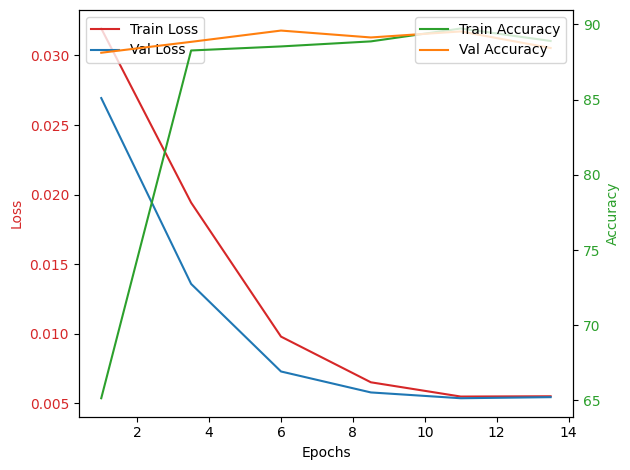

In [7]:
plotTrainValLoss(SoftHebb_loss, SoftHebb_valloss, name_model)

In [8]:
criterion = nn.CrossEntropyLoss()
loss_test, acc_test = evaluate_sup(SoftHebb_model, criterion, test_loader, device)

print(f'Accuracy of the model on the test images: {acc_test:.2f}%')

Accuracy of the model on the test images: 88.63%


In [9]:
name_model = "2SoftHebbCnnMNIST"
CNN_blocks = load_presets(name_model)
CNN_blocks = check_dimension(CNN_blocks, dataset_sup_config)
cnn_train_config = training_config(CNN_blocks, dataset_sup_config, dataset_unsup_config, params["training_mode"],
                                   params["training_blocks"])
SoftHebb_CNN_model = load_layers(CNN_blocks, "2SoftHebbCnnCIFAR", False)

block 0, size : 100 14 14
range = 5.0
range = 0.12371791482634838

 Model 2SoftHebbCnnCIFAR not found



 ----- Architecture Block BatchNorm2dS11002(5, 5)1.0reflect, number 0 -----
- BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
- HebbSoftConv2d(1, 100, lebesgue_p=2, pruning=0, kernel_size=(5, 5), bias=False, padding_mode=reflect, t_invert=1.0, bias=False, lr_bias=0.1, activation=exp)
- Triangle(power=0.7)
- AvgPool2d(kernel_size=4, stride=2, padding=1)

 ----- Architecture Block FlattenDropout(p=0.5, inplace=False)Linear(in_, number 1 -----
- Flatten(start_dim=1, end_dim=-1)
- Dropout(p=0.5, inplace=False)
- Linear(in_features=19600, out_features=10, bias=True)


In [10]:
log = Log(cnn_train_config)
config = cnn_train_config['t1']
total_epoch = 30

CnnHebb_loss, CnnHebb_valloss = train_model(
                                            total_epoch,
                                            5,
                                            0.001,
                                            name_model,
                                            SoftHebb_CNN_model,
                                            device,
                                            log.sup['t1'],
                                            blocks=config['blocks']
                                        )

# Save the model
torch.save({'state_dict': SoftHebb_CNN_model.state_dict(),
        'config': SoftHebb_CNN_model.config}, os.path.join("D:\\BlcRepo\OtherCode\\NeuroAI\\SoftHebb\\Models", "2SoftHebbCnnMNIST", f"2SoftHebbCnnMNIST.pth"))


 ********** Hybrid learning of blocks [0, 1] **********
Epoch: [1/100]	lr: 1.00e-03	time: 00:00:54	Loss_train 0.02030	Acc_train 84.24	/	Loss_test 0.00667	Acc_test 89.69
Epoch: [5/100]	lr: 1.00e-03	time: 00:04:19	Loss_train 0.01336	Acc_train 87.81	/	Loss_test 0.01239	Acc_test 90.97
Epoch: [10/100]	lr: 1.00e-03	time: 00:08:44	Loss_train 0.01848	Acc_train 89.44	/	Loss_test 0.01108	Acc_test 93.79
Epoch: [15/100]	lr: 1.00e-03	time: 00:13:03	Loss_train 0.02132	Acc_train 90.08	/	Loss_test 0.01207	Acc_test 94.28
Epoch: [20/100]	lr: 5.00e-04	time: 00:17:21	Loss_train 0.01755	Acc_train 91.24	/	Loss_test 0.00920	Acc_test 95.01
Epoch: [25/100]	lr: 2.50e-04	time: 00:21:36	Loss_train 0.01523	Acc_train 91.67	/	Loss_test 0.00876	Acc_test 94.92
Epoch: [30/100]	lr: 2.50e-04	time: 00:25:37	Loss_train 0.01349	Acc_train 91.97	/	Loss_test 0.00798	Acc_test 94.90


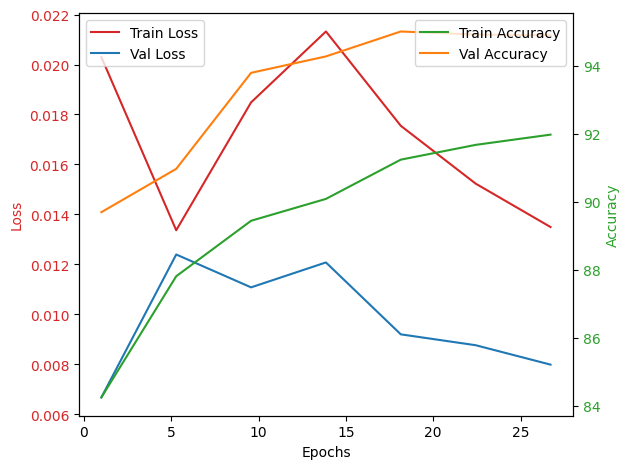

In [11]:
plotTrainValLoss(CnnHebb_loss, CnnHebb_valloss, name_model, total_epoch)

In [12]:
criterion = nn.CrossEntropyLoss()
loss_test, acc_test = evaluate_sup(SoftHebb_CNN_model, criterion, test_loader, device)

print(f'Accuracy of the model on the test images: {acc_test:.2f}%')

Accuracy of the model on the test images: 95.20%


In [13]:
## Examples of how to load pre-trained models

# Load the model
from model import MultiLayer

SoftMNIST = torch.load("D:\\BlcRepo\OtherCode\\NeuroAI\\SoftHebb\\Models\\2SoftMlpMNIST\\2SoftMlpMNIST.pth")

SoftMNIST_Model = MultiLayer(SoftMNIST['config'])
SoftMNIST_Model.load_state_dict(SoftMNIST['state_dict'])

SoftMNIST_Model.eval()